In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

#### Transformation 1 : Data augmentation with wealth data

In [42]:
energy = pd.read_csv("../Data/energy.csv")
wealth = pd.read_csv("../Data/wealth.csv")
idcols = [
    'Country',
    'Year',
    'Region'
]
nonrencols = [
    'coalprod_ej',
    'coalcons_ej',
    'oilprod_kbd',
    'oilcons_kbd',
]
wealthcols = [
    'GDP per capita, PPP (current international $)',
    'GDP, PPP (current international $)',
]

In [43]:
df = pd.merge(energy[idcols + nonrencols], wealth[(['Country', 'Year'] + wealthcols)], on = ['Country', 'Year'])
df.rename(columns={
    'GDP per capita, PPP (current international $)' : 'GDP_PPP_percap',
    'GDP, PPP (current international $)' : 'GDP_PPP'
}, inplace = True)
wealthcols = [
    'GDP_PPP_percap',
    'GDP_PPP'
]
df

,Country,Year,Region,coalprod_ej,coalcons_ej,oilprod_kbd,oilcons_kbd,GDP_PPP_percap,GDP_PPP
0,Algeria,1980,Africa,0.000000,0.002680,1134.182393,120.233251,0.000000,0.000000e+00
1,Algeria,1981,Africa,0.000000,0.001884,1029.279452,130.103589,0.000000,0.000000e+00
2,Algeria,1982,Africa,0.000000,0.034960,1039.656164,137.662000,0.000000,0.000000e+00
3,Algeria,1983,Africa,0.000000,0.031192,1026.933973,155.149233,0.000000,0.000000e+00
4,Algeria,1984,Africa,0.000000,0.034583,1122.489071,171.789672,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...
3005,Uzbekistan,2018,CIS,0.049068,0.085048,63.989380,94.794979,7289.329501,2.402279e+11
3006,Uzbekistan,2019,CIS,0.048335,0.075286,66.862478,95.015266,7717.744117,2.591645e+11
3007,Uzbekistan,2020,CIS,0.049540,0.103173,61.295969,99.962567,7822.661958,2.677858e+11
3008,Uzbekistan,2021,CIS,0.060067,0.092920,63.409973,110.719808,8607.527450,3.005327e+11


In [44]:
df.loc[1000]

Country                        Germany
Year                              1991
Region                          Europe
coalprod_ej                   4.444311
coalcons_ej                   4.836943
oilprod_kbd                        0.0
oilcons_kbd                2810.176192
GDP_PPP_percap            20996.187697
GDP_PPP           1679986778764.659912
Name: 1000, dtype: object

In [72]:
### using a modified Data Preprocessor class based off /Harsh/main.py

class Data:
    def __init__(self, df, year):
        self.df = df.copy()
        self.imputer = SimpleImputer(strategy="mean")
        self.encoder = OrdinalEncoder()
        self.year = year
        self.X = df.copy()
        self.X = self.get_year(year)
        # self.w_o_outliers = self.remove_all_outliers()
        
    def plot_outliers(self):
        pltdata = [
            len(self.w_o_outliers),
            len(self.X) - len(self.w_o_outliers)
        ]
        plt.pie(pltdata, labels = [f"Not Outliers - {pltdata[0]}", f"Outliers - {pltdata[1]}"])
        plt.show()

        
    def plot_outliers_for_col(self):
        figure, axis = plt.subplots(1, 2, figsize = (10, 6))
        pos = 0
        for col in wealthcols:
            axis[pos].set_title(f"Outliers for {col}", fontsize = 15)
            axis[pos].boxplot(self.X[col])
            pos += 1
        figure.tight_layout(pad = 1.0)
        plt.show()

    def get_year(self, year):
        grouped_data = self.X.groupby(['Year'])
        grouped_data.get_group(year)
        return grouped_data.get_group(year)
    
    def show_outliers(self, column):
        try:
            sns.boxplot(x=self.X[column])
            plt.show()
        except:
            print("There was some error while accessing the given column")

    def IQR(self):
        reqcols = []
        for col in self.X.columns:
            if col in idcols + ["torem"]: 
                continue
            reqcols.append(col)
        temp1 = self.X[reqcols].copy()
        temp2 = self.X[reqcols].copy()
        Q1 = (temp1).quantile(0.25)
        Q3 = (temp2).quantile(0.75)
        iqr = Q3-Q1
        return (Q1, Q3, iqr)
    
    def remove_all_outliers(self):
        Q1, Q3, IQR = self.IQR()
        prev = len(self.X.index)
        self.X["torem"] = True
        for col in self.X.columns:
            if col in idcols + ["torem"]:
                continue
            mask = ~((self.X[col] < (Q1[col] - 1.5 * IQR[col])) | (self.X[col] > (Q3[col] + 1.5 * IQR[col])))
            self.X['torem'] &= mask
        outliers_count = (self.X['torem'] == False).sum()
        print(f"{outliers_count} outliers were detected")
        return self.X[self.X["torem"]]
    
    def remove_outliers(self, col):
        sorts = self.X[col].sort_values()
        Q1 = sorts.quantile(0.25)
        Q3 = sorts.quantile(0.75)
        IQR = Q3-Q1
        prev = len(self.X.index)
        return sorts[~((sorts < (Q1 - 1.5 * IQR)) |
                         (sorts > (Q3 + 1.5 * IQR)))]

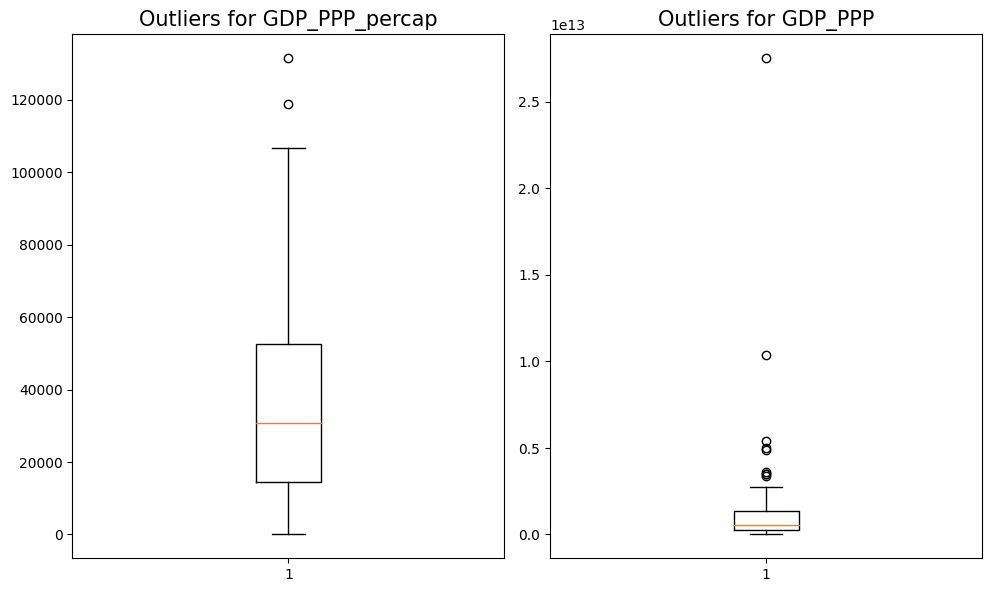

In [73]:
data = Data(df, year = 2021)
data.plot_outliers_for_col()

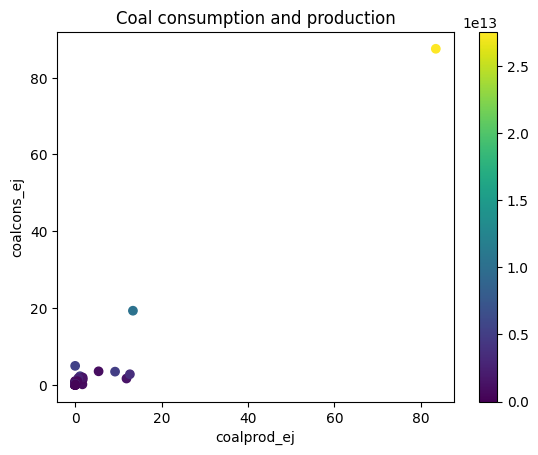

In [74]:
### Scatter plot color mapped according to GDP

def plotScatter(data, x, y, c, title):
    plt.scatter(data[x], data[y], c = data[c])
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar()
    plt.show()
    
plotScatter(data.X, "coalprod_ej", "coalcons_ej", "GDP_PPP", "Coal consumption and production")

In [75]:
df.head()

,Country,Year,Region,coalprod_ej,coalcons_ej,oilprod_kbd,oilcons_kbd,GDP_PPP_percap,GDP_PPP
0,Algeria,1980,Africa,0.0,0.002680,1134.182393,120.233251,0.0,0.0
1,Algeria,1981,Africa,0.0,0.001884,1029.279452,130.103589,0.0,0.0
2,Algeria,1982,Africa,0.0,0.034960,1039.656164,137.662000,0.0,0.0
3,Algeria,1983,Africa,0.0,0.031192,1026.933973,155.149233,0.0,0.0
4,Algeria,1984,Africa,0.0,0.034583,1122.489071,171.789672,0.0,0.0


17 outliers were detected


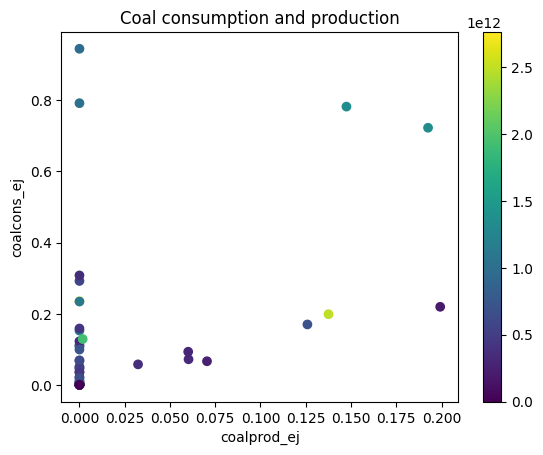

In [76]:
data = Data(df[idcols + ["coalprod_ej", "coalcons_ej", "GDP_PPP"]], year=2021)
plotScatter(data.remove_all_outliers(), "coalprod_ej", "coalcons_ej", "GDP_PPP", "Coal consumption and production")

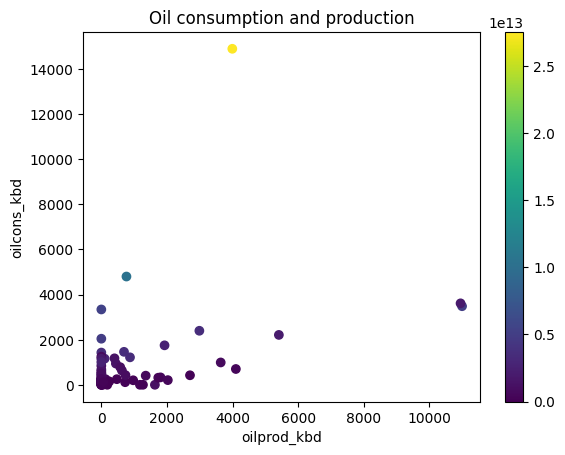

In [77]:
data = Data(df[idcols + ["oilprod_kbd", "oilcons_kbd", "GDP_PPP"]], year=2021)
plotScatter(data.X, "oilprod_kbd", "oilcons_kbd", "GDP_PPP", "Oil consumption and production")

14 outliers were detected


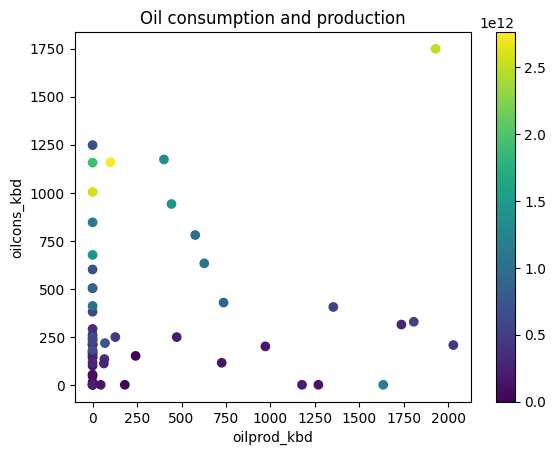

In [78]:
plotScatter(data.remove_all_outliers(), "oilprod_kbd", "oilcons_kbd", "GDP_PPP", "Oil consumption and production")

#### Transformation 2 : Log Transforms

In [80]:
import math

In [81]:
epsilon = 1e-10
def applyLogTransform(data, firstCol, secondCol, resultCol):
    data[resultCol] = ((data[firstCol] + epsilon)/(data[secondCol] + epsilon)).apply(lambda x : math.log(x, 10))

applyLogTransform(df, firstCol = "coalprod_ej", secondCol = "coalcons_ej", resultCol = "self_sufficiency_coal")
applyLogTransform(df, firstCol = "oilprod_kbd", secondCol = "oilcons_kbd", resultCol = "self_sufficiency_oil")
df

,Country,Year,Region,coalprod_ej,coalcons_ej,oilprod_kbd,oilcons_kbd,GDP_PPP_percap,GDP_PPP,self_sufficiency_coal,self_sufficiency_oil
0,Algeria,1980,Africa,0.000000,0.002680,1134.182393,120.233251,0.000000,0.000000e+00,-7.428062,0.974658
1,Algeria,1981,Africa,0.000000,0.001884,1029.279452,130.103589,0.000000,0.000000e+00,-7.275095,0.898244
2,Algeria,1982,Africa,0.000000,0.034960,1039.656164,137.662000,0.000000,0.000000e+00,-8.543569,0.878076
3,Algeria,1983,Africa,0.000000,0.031192,1026.933973,155.149233,0.000000,0.000000e+00,-8.494038,0.820793
4,Algeria,1984,Africa,0.000000,0.034583,1122.489071,171.789672,0.000000,0.000000e+00,-8.538862,0.815185
...,...,...,...,...,...,...,...,...,...,...,...
3005,Uzbekistan,2018,CIS,0.049068,0.085048,63.989380,94.794979,7289.329501,2.402279e+11,-0.238862,-0.170677
3006,Uzbekistan,2019,CIS,0.048335,0.075286,66.862478,95.015266,7717.744117,2.591645e+11,-0.192458,-0.152611
3007,Uzbekistan,2020,CIS,0.049540,0.103173,61.295969,99.962567,7822.661958,2.677858e+11,-0.318606,-0.212405
3008,Uzbekistan,2021,CIS,0.060067,0.092920,63.409973,110.719808,8607.527450,3.005327e+11,-0.189473,-0.242068


In [103]:
data = Data(df, year=2021)

In [104]:
from sklearn.cluster import KMeans
def plot_clusters(x, y, num_clusters, xlabel, ylabel, title, ptlabel = None):
    data = list(zip(x, y))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)
    labels = kmeans.labels_
    plt.scatter(x, y, c=labels, cmap='viridis', edgecolor='k', s=30)
    plt.title(title)
    if ptlabel is not None :
        ind = 0
        for (i, j) in data:
            plt.text(i, j, ptlabel[ind], fontsize = 6)
            ind += 1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [109]:
data.X[["self_sufficiency_coal", "Country"]]

,self_sufficiency_coal,Country
41,-8.048393,Algeria
84,0.000000,Angola
127,-8.704053,Argentina
170,0.863319,Australia
213,-9.032474,Austria
...,...,...
2836,0.000000,Turkmenistan
2879,-0.243371,Ukraine
2922,-8.995723,United Arab Emirates
2965,-0.907991,United Kingdom


c:\Users\subha\miniconda3\envs\dv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\subha\miniconda3\envs\dv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


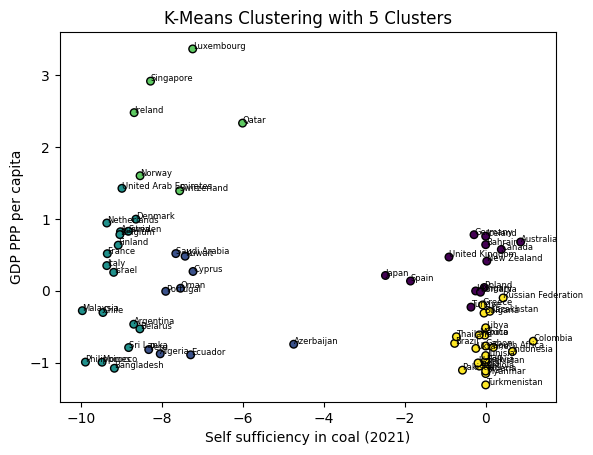

In [111]:
num_clusters = 5
scaler = StandardScaler()
data.X[['GDP_PPP_percap']] = scaler.fit_transform(data.X[['GDP_PPP_percap']])
plot_clusters(
    data.X['self_sufficiency_coal'], 
    data.X['GDP_PPP_percap'], 
    num_clusters, 
    'Self sufficiency in coal (2021)', 
    'GDP PPP per capita', 
    f'K-Means Clustering with {num_clusters} Clusters',
    list(data.X["Country"]), 
)

c:\Users\subha\miniconda3\envs\dv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\subha\miniconda3\envs\dv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


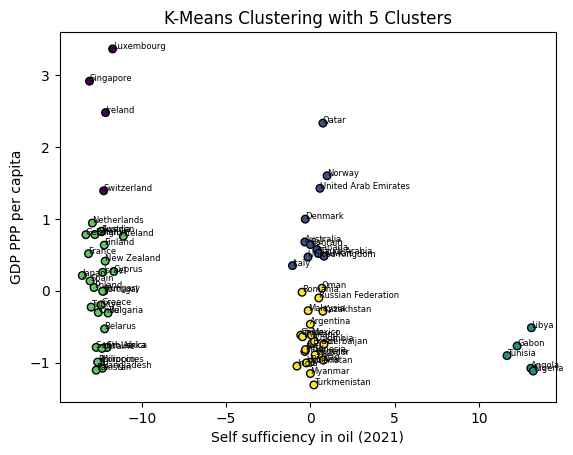

In [112]:
num_clusters = 5
scaler = StandardScaler()
data.X[['GDP_PPP_percap']] = scaler.fit_transform(data.X[['GDP_PPP_percap']])
plot_clusters(
    data.X['self_sufficiency_oil'], 
    data.X['GDP_PPP_percap'], 
    num_clusters, 
    'Self sufficiency in oil (2021)', 
    'GDP PPP per capita', 
    f'K-Means Clustering with {num_clusters} Clusters',
      list(data.X["Country"]), 
)

#### Transformation 3 : Total Production over the years

In [94]:
wealthcols = [
    'Country', 'Year',
    'GDP, PPP (current international $)'
]
timeSeriesData = pd.merge(energy[idcols + nonrencols], wealth[wealthcols], on = ['Country', 'Year']).groupby('Year').sum()
timeSeriesData.rename(columns={
    'GDP, PPP (current international $)' : 'GDP_PPP'
}, inplace = True)
wealthcols = [
    'GDP_PPP_percap',
    'GDP_PPP'
]
timeSeriesData.head()

,Country,Region,coalprod_ej,coalcons_ej,oilprod_kbd,oilcons_kbd,GDP_PPP
Year,,,,,,,
1980,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.000000,40.820564,34923.368465,31102.659587,0.0
1981,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,39.089617,41.301983,31557.699406,30125.379166,0.0
1982,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,41.271207,42.323105,28262.415180,29256.500161,0.0
1983,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,42.372813,43.799123,27388.621657,29006.273173,0.0
1984,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,43.434647,45.844490,28517.040842,29699.436580,0.0


In [95]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
timeSeriesData[nonrencols + ['GDP_PPP']] = scaler.fit_transform(timeSeriesData[nonrencols + ['GDP_PPP']])
    
timeSeriesData.head()

,Country,Region,coalprod_ej,coalcons_ej,oilprod_kbd,oilcons_kbd,GDP_PPP
Year,,,,,,,
1980,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.000000,0.000000,0.176634,0.057590,0.0
1981,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.248469,0.004773,0.097734,0.030743,0.0
1982,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.262336,0.014898,0.020484,0.006874,0.0
1983,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.269338,0.029534,0.000000,0.000000,0.0
1984,AlgeriaAngolaArgentinaAustraliaAustriaAzerbaij...,AfricaAfricaS. & Cent. AmericaAsia PacificEuro...,0.276087,0.049815,0.026453,0.019042,0.0


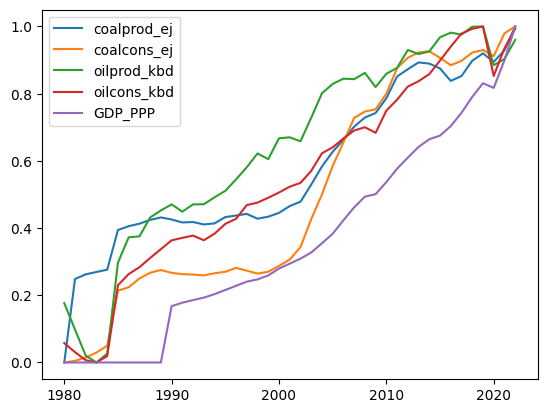

In [96]:
for col in (nonrencols + ['GDP_PPP']):
    plt.plot(timeSeriesData.index, timeSeriesData[col], label = col)
plt.legend()
plt.show()